# Assignment 8: Ge'ez character recognition

## Data-preperation

In [ ]:
!pip3 install Pillow

In [ ]:
!pip3 install tensorflow

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
#from keras.datasets import mnist

import shutil
from google.colab import files
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
geezFile1 = files.upload()

Saving Amharic Character Dataset 1.rar to Amharic Character Dataset 1.rar


In [ ]:
geezFile2 = files.upload()

Saving Amharic Character Dataset 2.rar to Amharic Character Dataset 2.rar


In [ ]:
# Makes a folder into which it unrars both files
!rm datafolder -rf
!mkdir "datafolder" -p
%cd "datafolder"
!unrar e "../Amharic Character Dataset 1.rar"
!unrar e "../Amharic Character Dataset 2.rar"
%cd ".."

In [ ]:
p = Path('datafolder')
unsortedLabels = [(x.name).split(".")[0] for x in p.iterdir() if not x.is_dir()]
sortedLabels = sorted(unsortedLabels)

In [ ]:
# Deletes and remakes the datafolder with categories
!rm datafoldercat -rf
!mkdir "datafoldercat" -p

In [ ]:
# Copies all files from datafolder into the catagorically sorted one
# And creates new folders for each different character
newp = Path('datafoldercat')

for x in p.iterdir():
  curname = (x.name).split(".")[0]
  curpath = Path("datafoldercat" + "/" + curname)
  curpath.mkdir(parents=True, exist_ok=True)
  shutil.copy(x, ("datafoldercat" + "/" + curname))

In [ ]:
thedata = tf.keras.utils.image_dataset_from_directory("datafoldercat", image_size=(28, 28), color_mode='grayscale')

Found 37652 files belonging to 238 classes.


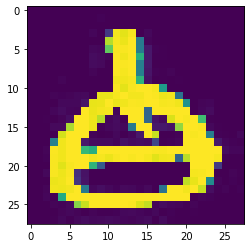

In [ ]:
data_r = thedata.as_numpy_iterator().next()
plt.imshow(data_r[0][0].astype(int))

In [ ]:
trainDatasetr = tf.keras.utils.image_dataset_from_directory(
    "datafoldercat",
    image_size=(28, 28),
    validation_split = 0.2,
    subset = "training",
    seed = 12345,
    shuffle = True,
    color_mode='grayscale'
    )

valDatasetr = tf.keras.utils.image_dataset_from_directory(
    "datafoldercat",
    image_size=(28, 28),
    validation_split = 0.2,
    subset = "validation",
    seed = 12345,
    shuffle = True,
    color_mode='grayscale'
    )

Found 37652 files belonging to 238 classes.
Using 30122 files for training.
Found 37652 files belonging to 238 classes.
Using 7530 files for validation.


In [ ]:
def tupdiv(x,y):
  return (tf.cast(x/255. ,tf.float32),y)

trainDataset = trainDatasetr.map(tupdiv)
valDataset   = valDatasetr.map(tupdiv)

## Models and training

In [ ]:
def make_Network(imSize,numClasses):


  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape = (imSize,imSize,1), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  model.add(Conv2D(32, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  model.add(Flatten())
  model.add(Dense(units = 256, activation = 'relu'))
  # Units are equal to the number of classes
  model.add(Dense(units = numClasses, activation = 'softmax'))

  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  model.summary()

  return model

In [ ]:
model1 = make_Network(28,238)
reportHist = model1.fit(trainDataset,
          batch_size=32,
          epochs=15,
          validation_data=valDataset);

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 800)               0         
                                                                 
 dense_28 (Dense)            (None, 256)             

In [ ]:
# Plots different values of interest from the epochs of training
def plot_Accuracy(r):
  plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
  plt.plot(r.history['accuracy'], label='accuracy')
  plt.plot(r.history['loss'], label='loss')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.ylim([0.4, 1])
  plt.legend(loc='lower left')
  plt.title("Accuracy of the model")

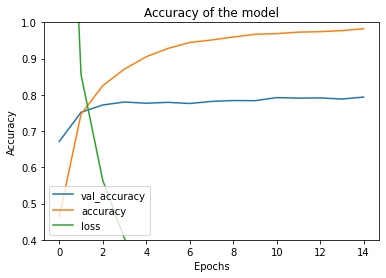

In [ ]:
plot_Accuracy(reportHist)

# SVM model

Upload the data as shown below, so that it fits with the code.

In [ ]:
!rm data -rf
!mkdir "data" -p
%cd "data"
!unrar e "../Amharic Character Dataset 1.rar"
!unrar e "../Amharic Character Dataset 2.rar"
%cd ".."

In [ ]:
import numpy as np
import cv2
import os
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage.feature import hog

# Load the dataset
data_dir = 'data'
char_images = []
char_labels = []
for image_path in os.listdir(data_dir):
     if image_path.endswith('.jpg'):
        image = cv2.imread(os.path.join(data_dir, image_path), 0)
        image = cv2.resize(image, (64, 64))
        char_images.append(image)
        label = image_path.split('.')[0]
        char_labels.append(label)

# Extract HOG features from the images
hog_features = []
for image in char_images:
    feature = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    hog_features.append(feature)
X = np.array(hog_features)
y = np.array(char_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM classifier
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Evaluate the performance of the classifier
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.8405333333333334
